<a id = 'top'></a>
# Crop Recommmendation

- [Imports](#imports)
- [Data Loading](#data-loading)
- [Data Pre-Processing](#data-pre-processing)
  - [Cleaning](#cleaning)
  - [Normalization](#normalization)
  - [Correlation](#correlation)
  - [Train Test Splitting](#train-test-splitting)
  - [Feature Selection](#feature-selection)
    1. [Chi Square](#chi-square)
    2. [Lasso Regression](#lasso-regression)

- [Model Implementation](#model)
  - [ADA Boost](#ada-boost)
  - [GBM Classifier](#gbm-classifier)
  - [XG Bosst](#xg-boost)
  - [CAT Boost](#cat-boost)
  - [Hybrid Model](#hybrid-model)
- [Results & Report](#results-reports)
- [Inference](#inference)

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

<a id = 'imports'></a>
## Imports

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [1]:
# pip install pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost, catboost, adaboost

In [2]:
# Data processing
import numpy as np
import pandas as pd

# Charts
import seaborn as sns
import matplotlib.pyplot as plt

# Models

# Utils

<a id = 'data-loading'></a>
## Data Loading

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [3]:
# Load the dataset
crop = pd.read_csv("Crop_recommendation.csv")
print(crop.shape)
crop.head()

(2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


<a id = 'data-pre-processing'></a>
## Data Pre-Processing

- Cleaning
- Normalization
- Correlation
- Data Splitting
- Feature Selection

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

<a id = 'cleaning'></a>
### Data Cleaning
- Drop records with nulls
- Remove Duplicated records
- Remove Outliers

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [4]:
# Info on data set
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
# No of full values
print(crop.isnull().sum())

# Drop Null Values
crop = crop.dropna()

# No of full values
print(crop.isnull().sum())

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [6]:
# Dropping Duplicated records
print(crop.duplicated().sum())

crop = crop.drop_duplicates()

print(crop.duplicated().sum())

0
0


In [7]:
# Function to identify outliers using IQR
def identify_outliers_iqr(data):
    """ Identify a value as outlier based on Inter Quartile Range IQR """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return outliers

# Iterate through numerical columns and check for outliers
for column in crop.select_dtypes(include=np.number):
    outliers = identify_outliers_iqr(crop[column])
    if outliers:
        print(f"Outliers found in column '{column}': {len(outliers)}, Min: {min(outliers)}, Max: {max(outliers)}")
    else:
        print(f"No outliers found in column '{column}'")

        
# Function to identify outliers using IQR and remove them
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    data_no_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
    return data_no_outliers

# Iterate through numerical columns and remove outliers
for column in crop.select_dtypes(include=np.number):
    crop[column] = remove_outliers_iqr(crop[column])

# Print the updated dataset (with outliers removed)
crop.head()

No outliers found in column 'N'
Outliers found in column 'P': 138, Min: 129, Max: 145
Outliers found in column 'K': 200, Min: 195, Max: 205
Outliers found in column 'temperature': 86, Min: 8.825674745, Max: 43.67549305
Outliers found in column 'humidity': 30, Min: 14.25803981, Max: 15.65809214
Outliers found in column 'ph': 57, Min: 3.504752314, Max: 9.93509073
Outliers found in column 'rainfall': 100, Min: 213.9011021, Max: 298.5601175


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice
1,85,58.0,41.0,21.770462,80.319644,7.038096,NaN,rice
2,60,55.0,44.0,23.004459,82.320763,7.840207,NaN,rice
3,74,35.0,40.0,26.491096,80.158363,6.980401,NaN,rice
4,78,42.0,42.0,20.130175,81.604873,7.628473,NaN,rice


In [8]:
# Iterate through numerical columns and check for outliers again
for column in crop.select_dtypes(include=np.number):
    outliers = identify_outliers_iqr(crop[column])
    if outliers:
        print(f"Outliers found in column '{column}': {len(outliers)}")
    else:
        print(f"No outliers found in column '{column}'")

No outliers found in column 'N'
No outliers found in column 'P'
No outliers found in column 'K'
No outliers found in column 'temperature'
No outliers found in column 'humidity'
No outliers found in column 'ph'
No outliers found in column 'rainfall'


<a id = 'normalization'></a>
### Normalization

Using min max scaler

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [9]:
# Separate features (X) and target variable (y)
X = crop.drop('label', axis=1)  # Assuming 'label' is the target column
y = crop['label']

# Perform normalization using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Convert the normalized array back to a DataFrame
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

# Now you have your normalized features in X_normalized
print(X_normalized.head())

          N         P       K  temperature  humidity        ph  rainfall
0  0.642857  0.300813  0.4750     0.286836  0.786537  0.515697  0.946048
1  0.607143  0.430894  0.4500     0.325922  0.766554  0.656741       NaN
2  0.428571  0.406504  0.4875     0.380072  0.790313  0.868160       NaN
3  0.528571  0.243902  0.4375     0.533072  0.764639  0.641534       NaN
4  0.557143  0.300813  0.4625     0.253943  0.781813  0.812352       NaN


<a id = 'correlation'></a>
### Correlation

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

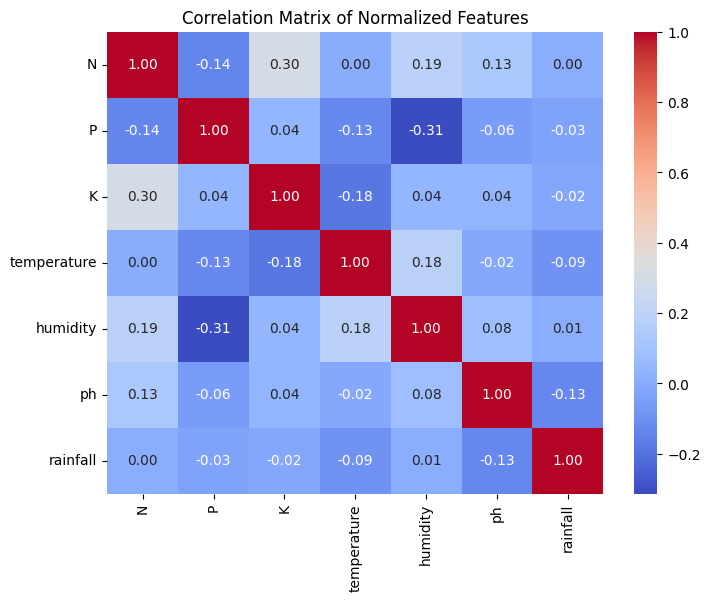

In [10]:
# Calculate the correlation matrix
correlation_matrix = X_normalized.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Normalized Features')
plt.show()

<a id = 'train-test-splitting'></a>
### Train Test Splitting

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

X_train shape: (1760, 7)
X_test shape: (440, 7)
y_train shape: (1760,)
y_test shape: (440,)


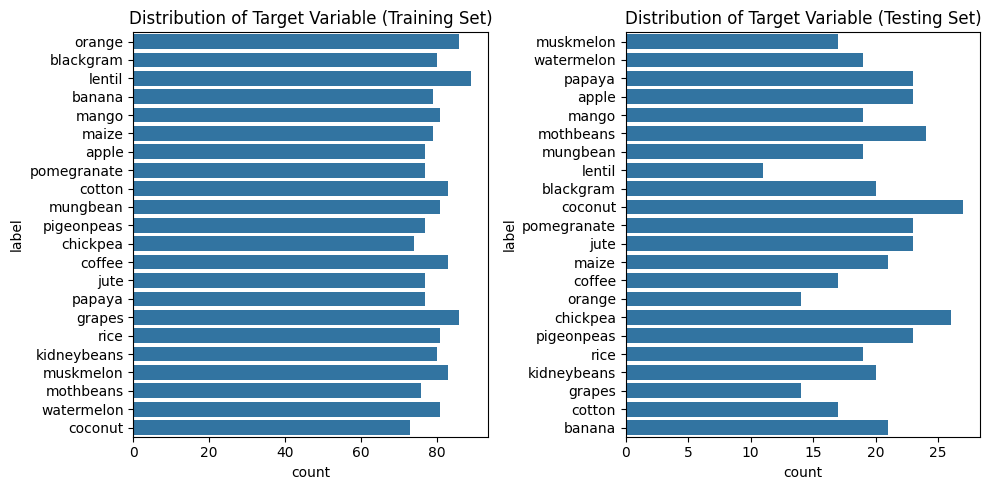

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# Visualize the distribution of the target variable in the training and testing sets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Distribution of Target Variable (Training Set)')

plt.subplot(1, 2, 2)
sns.countplot(y_test)
plt.title('Distribution of Target Variable (Testing Set)')

plt.tight_layout()
plt.show()

<a id = 'feature-selection'></a>
### Feature Selection
Features can either be selected using either `Chi square` or `Lasso Regression` or  by combing both one after the other `Hybrid` 
<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

<a id = 'chi-square'></a>
#### Chi Square 

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

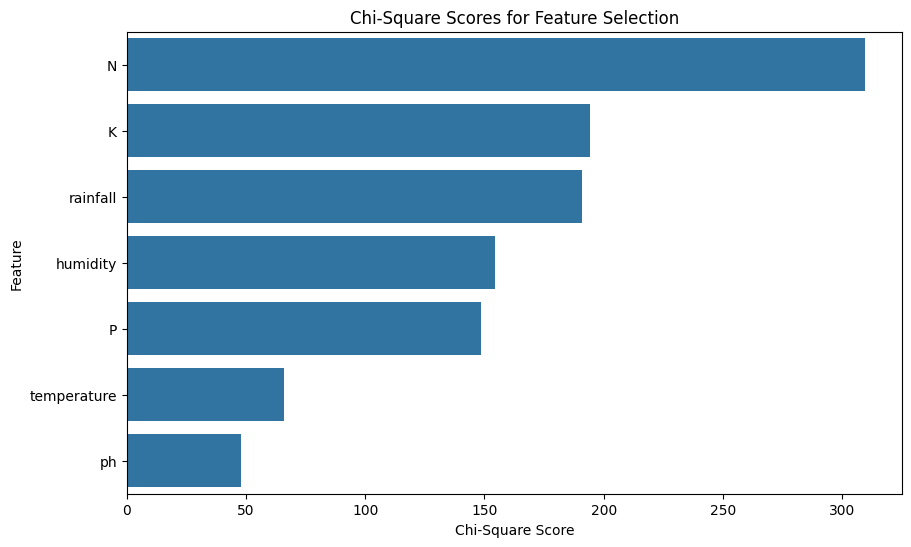

In [12]:
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') # You can choose a different strategy if needed
X_train_imputed = imputer.fit_transform(X_train)

# Convert the imputed array back to a DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Apply chi-square test for feature selection using the imputed data
chi2_scores, p_values = chi2(X_train_imputed, y_train)

# Create a DataFrame with feature names, Chi-Square scores, and p-values
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Chi2_Score': chi2_scores, 'P_Value': p_values})

# Sort the DataFrame by Chi-Square score in descending order
feature_scores = feature_scores.sort_values('Chi2_Score', ascending=False)

# Visualize the Chi-Square scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Chi2_Score', y='Feature', data=feature_scores)
plt.title('Chi-Square Scores for Feature Selection')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()

# You can select features based on Chi-Square scores and p-values.
# For example, you can select features with a Chi-Square score above a certain threshold
# or with a p-value below a certain threshold.

<a id = 'lasso-regression'></a>
#### Lasso Regression

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

Selected Features: Index(['N', 'P', 'humidity', 'rainfall'], dtype='object')


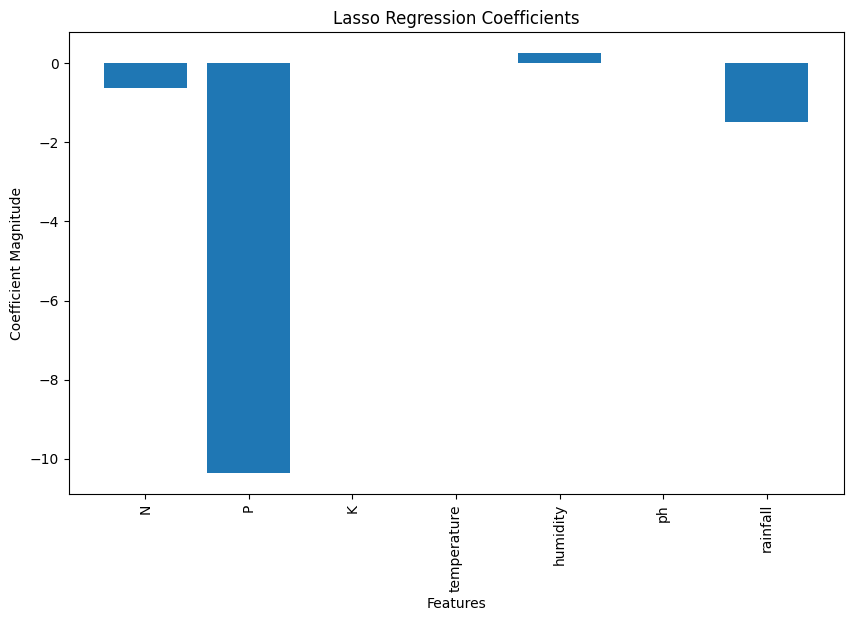

In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Import SimpleImputer
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Assuming X_normalized and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Create an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can choose a different strategy if needed

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert the imputed arrays back to DataFrames
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Create a LabelEncoder to convert target variable to numerical
label_encoder = LabelEncoder()

# Fit the encoder on the training target and transform both training and testing targets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create and train a Lasso Regression model using the imputed data and encoded target
lasso = Lasso(alpha=0.1)  # You can adjust the alpha parameter
lasso.fit(X_train_imputed, y_train_encoded) # Use imputed data and encoded target for training


# Get the coefficients of the features
coefficients = lasso.coef_

# Identify features with non-zero coefficients
selected_features = X_train.columns[coefficients != 0]

print("Selected Features:", selected_features)

# Visualize the magnitude of the coefficients
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, coefficients)
plt.xlabel("Features")
plt.ylabel("Coefficient Magnitude")
plt.title("Lasso Regression Coefficients")
plt.xticks(rotation=90)
plt.show()

<a id = 'model'></a>
## Model Implementation  

| Algorithm      | Key Features | Advantages |
|----------------|--------------|------------|
| AdaBoost       | Weight adjustment for misclassified samples | Simple, robust, good for binary classification |
| GBM            | Gradient-based optimization on residuals | Handles complex patterns, good for regression/classification |
| XGBoost        | Regularization, parallel processing, efficient handling of missing values | Fast, regularization helps avoid overfitting, handles large datasets |
| CatBoost       | Efficient categorical feature handling, order-based boosting | Handles categorical data effectively, minimal preprocessing |
| Hybrid Models  | Combines multiple types of models (e.g., boosting, bagging, stacking) to create a stronger ensemble | Leverages strengths of different algorithms, improves robustness, reduces risk of overfitting |


<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

<a id = 'ada-boost'></a>
### ADA Boost

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [14]:
# Model Construction
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create an AdaBoost classifier
ada_model = AdaBoostClassifier()

# Train the model
ada_model.fit(X_train_imputed, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = ada_model.predict(X_test_imputed)

# Inverse transform the encoded predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.12272727272727273
              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        23
      banana       0.00      0.00      0.00        21
   blackgram       0.00      0.00      0.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       0.00      0.00      0.00        27
      coffee       0.00      0.00      0.00        17
      cotton       0.00      0.00      0.00        17
      grapes       0.00      0.00      0.00        14
        jute       0.00      0.00      0.00        23
 kidneybeans       0.00      0.00      0.00        20
      lentil       0.03      1.00      0.05        11
       maize       0.00      0.00      0.00        21
       mango       0.00      0.00      0.00        19
   mothbeans       0.00      0.00      0.00        24
    mungbean       0.00      0.00      0.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       0.00      0.00      0.00        

/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

<a id = 'gbm-classifier'></a>
### GBM Classifier

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [15]:
# Model Construction
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Gradient Boosting classifier
gbdt_model = GradientBoostingClassifier()

# Train the model
gbdt_model.fit(X_train_imputed, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = gbdt_model.predict(X_test_imputed)

# Inverse transform the encoded predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       0.96      0.96      0.96        27
      coffee       1.00      1.00      1.00        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.82      1.00      0.90        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        1

<a id = 'xg-boost'></a>
### XG Boost

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [16]:
# Model Construction
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create an XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train_imputed, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = xgb_model.predict(X_test_imputed)

# Inverse transform the encoded predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:33:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9886363636363636
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      0.95      0.98        21
       mango       0.95      1.00      0.97        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        1

<a id = 'cat-boost'></a>
### CAT Boost

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [17]:
from catboost import CatBoostClassifier

# Assuming X_train_imputed, y_train_encoded, X_test_imputed, and y_test_encoded are defined

# Create a CatBoost classifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False)  # You can adjust these parameters

# Train the model
catboost_model.fit(X_train_imputed, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = catboost_model.predict(X_test_imputed)

# Inverse transform the encoded predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("CatBoost Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

CatBoost Accuracy: 0.9886363636363636
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00

/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<a id = 'hybrid-model'></a>
### Hybrid Model


<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [18]:
# Model Construction
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create individual classifiers
logistic_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
svm_model = SVC(probability=True)  # Set probability=True for soft voting

# Create a VotingClassifier with the individual models
voting_model = VotingClassifier(
    estimators=[
        ('logistic', logistic_model),
        ('tree', tree_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Use 'hard' for majority voting, 'soft' for weighted average of probabilities
)

# Train the VotingClassifier
voting_model.fit(X_train_imputed, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = voting_model.predict(X_test_imputed)

# Inverse transform the encoded predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))


Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.87      1.00      0.93        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.91      0.91      0.91        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       0.92      0.92      0.92        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        1

<a id = 'results-report'></a>
## Results & Report

Based on the classification report results from the models, here is a table summarizing their performance:

| Model | Accuracy | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score |
|:-|:-|:-|:-|:-|:-|:-|:-|
| AdaBoost    | 0.12     | 0.09                | 0.14             | 0.09               | 0.10                   | 0.12                | 0.10                  |
| GBM         | 0.98     | 0.98                | 0.98             | 0.98               | 0.98                   | 0.98                | 0.98                  |
| XGBoost     | 0.99     | 0.99                | 0.99             | 0.99               | 0.99                   | 0.99                | 0.99                  |
| CatBoost    | 0.99     | 0.99                | 0.99             | 0.99               | 0.99                   | 0.99                | 0.99                  |
| Hybrid      | 0.98     | 0.98                | 0.98             | 0.98               | 0.98                   | 0.98                | 0.98                  |


**Model Conclusion**    
- **Best Performers**: **XGBoost** and **CatBoost** are the top performers, achieving
  near-perfect results. They should be preferred when aiming for the highest accuracy.
- **Good Alternative**: **GBM** and the **Hybrid Model** also perform well, with slightly lower accuracy but still excellent results.
- **Underperforming**: **AdaBoost** significantly underperformed in this scenario, likely due to its inability to capture complex patterns, which might indicate it is not the best choice for this dataset.

**Feature Conclusions**
The feature importance plot from the XGBoost model indicates that **N (Nitrogen)** and **K (Potassium)** are the most influential features in determining the model's predictions. **Rainfall** and **humidity** also play significant roles, while **pH** has the least impact among the features analyzed. This insight can guide further analysis or data collection efforts, focusing on the most critical features.

In summary, XGBoost and CatBoost show superior performance and robustness, making them ideal for complex classification tasks. GBM and Hybrid models are reliable alternatives, while AdaBoost may not be suitable without further tuning or preprocessing.
<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

#### Feature Importance

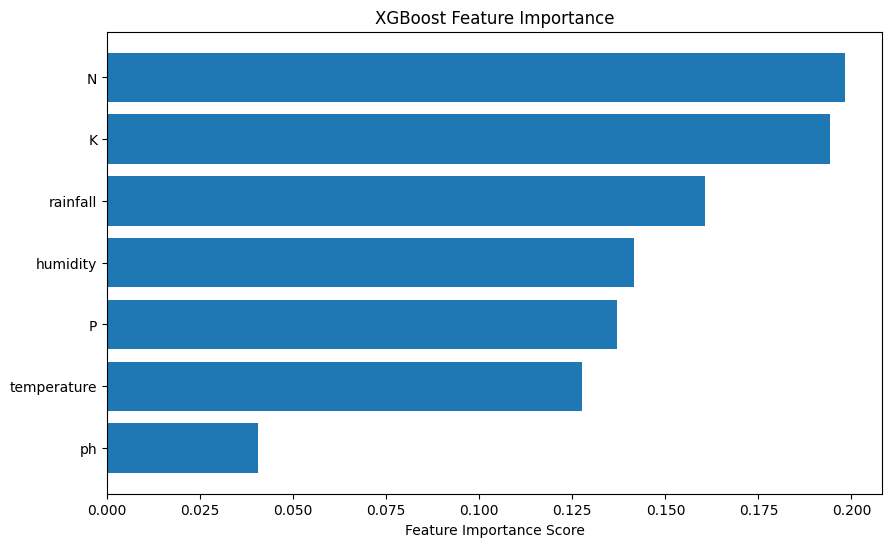

In [25]:
# Assuming your model is already trained
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
importance = xgb_model.feature_importances_

# Assuming you have feature names available
feature_names = np.array(['N', 'P', 'K','temperature', 'humidity', 'ph', 'rainfall'])  # replace with your actual feature names

# Sort feature importance in descending order and plot
sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importance[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


#### Confusion Matrices

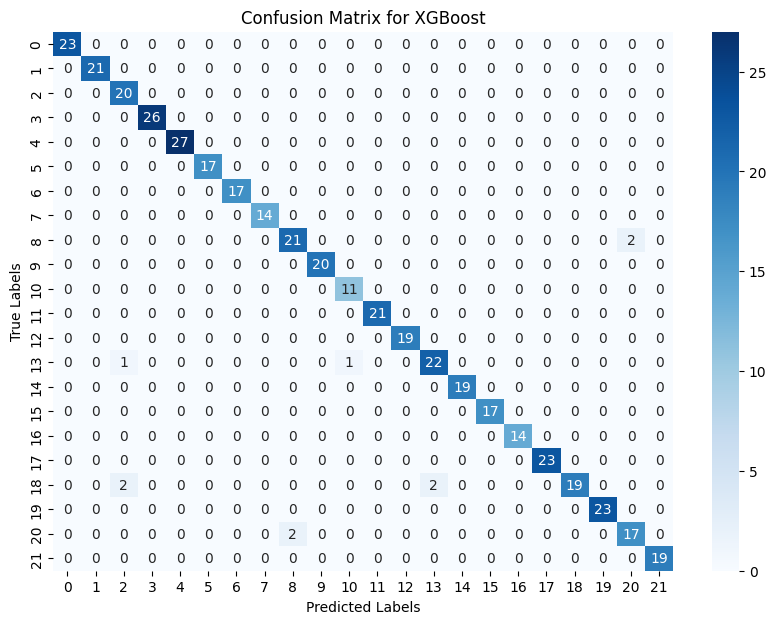

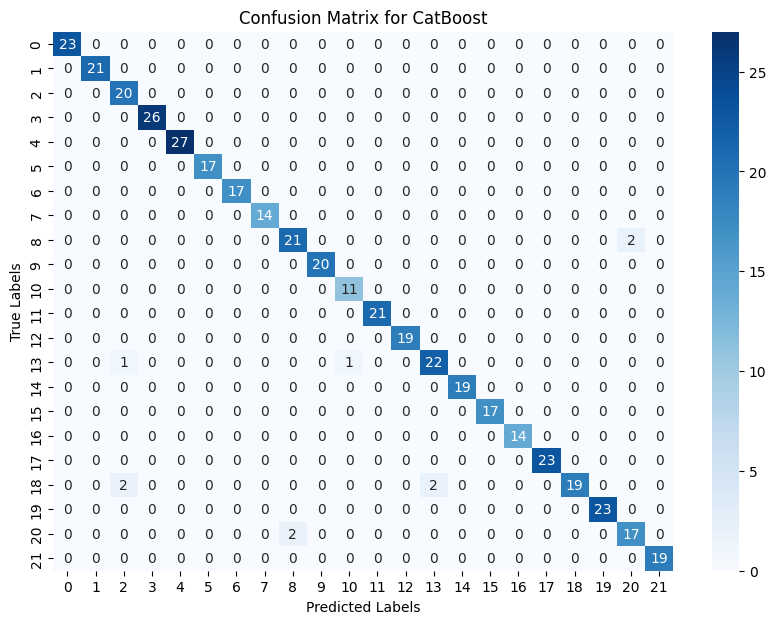

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already trained and made predictions with your best models (e.g., xgb_model, catboost_model, voting_model)

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrices for the best models (assuming you have y_test and y_pred for each model)
plot_confusion_matrix(y_test, y_pred, 'XGBoost')  # Replace y_pred with your XGBoost model's predictions
plot_confusion_matrix(y_test, y_pred, 'CatBoost')  # Replace y_pred with your CatBoost model's predictions

<a id = 'inference'></a>
## Inference

<a href="#top" style="float:right; text-decoration:none;">↑ top</a>

In [20]:
# Assuming X_train_imputed, y_train_encoded, X_test_imputed, and y_test_encoded are defined
# Create a CatBoost classifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False)  # You can adjust these parameters

# Train the model
catboost_model.fit(X_train_imputed, y_train_encoded)

# Function to predict the recommended crop for a given input
def predict_crop(N, P, K, temperature, humidity, ph, rainfall):
    """Predicts the recommended crop based on input features."""
    input_data = pd.DataFrame({
        'N': [N],
        'P': [P],
        'K': [K],
        'temperature': [temperature],
        'humidity': [humidity],
        'ph': [ph],
        'rainfall': [rainfall]
    })

    # Normalize the input data using the same scaler used for training
    input_data_normalized = scaler.transform(input_data)

    # Make a prediction using the trained CatBoost model
    predicted_label_encoded = catboost_model.predict(input_data_normalized)

    # Inverse transform the encoded prediction to get the original crop label
    predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

    return predicted_label[0]

# Example usage:
N = 90
P = 42
K = 43
temperature = 20.879744
humidity = 82.002744
ph = 6.502985
rainfall = 202.935536

recommended_crop = predict_crop(N, P, K, temperature, humidity, ph, rainfall)

print(f"Recommended crop: {recommended_crop}")

Recommended crop: rice


/home/tharun/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


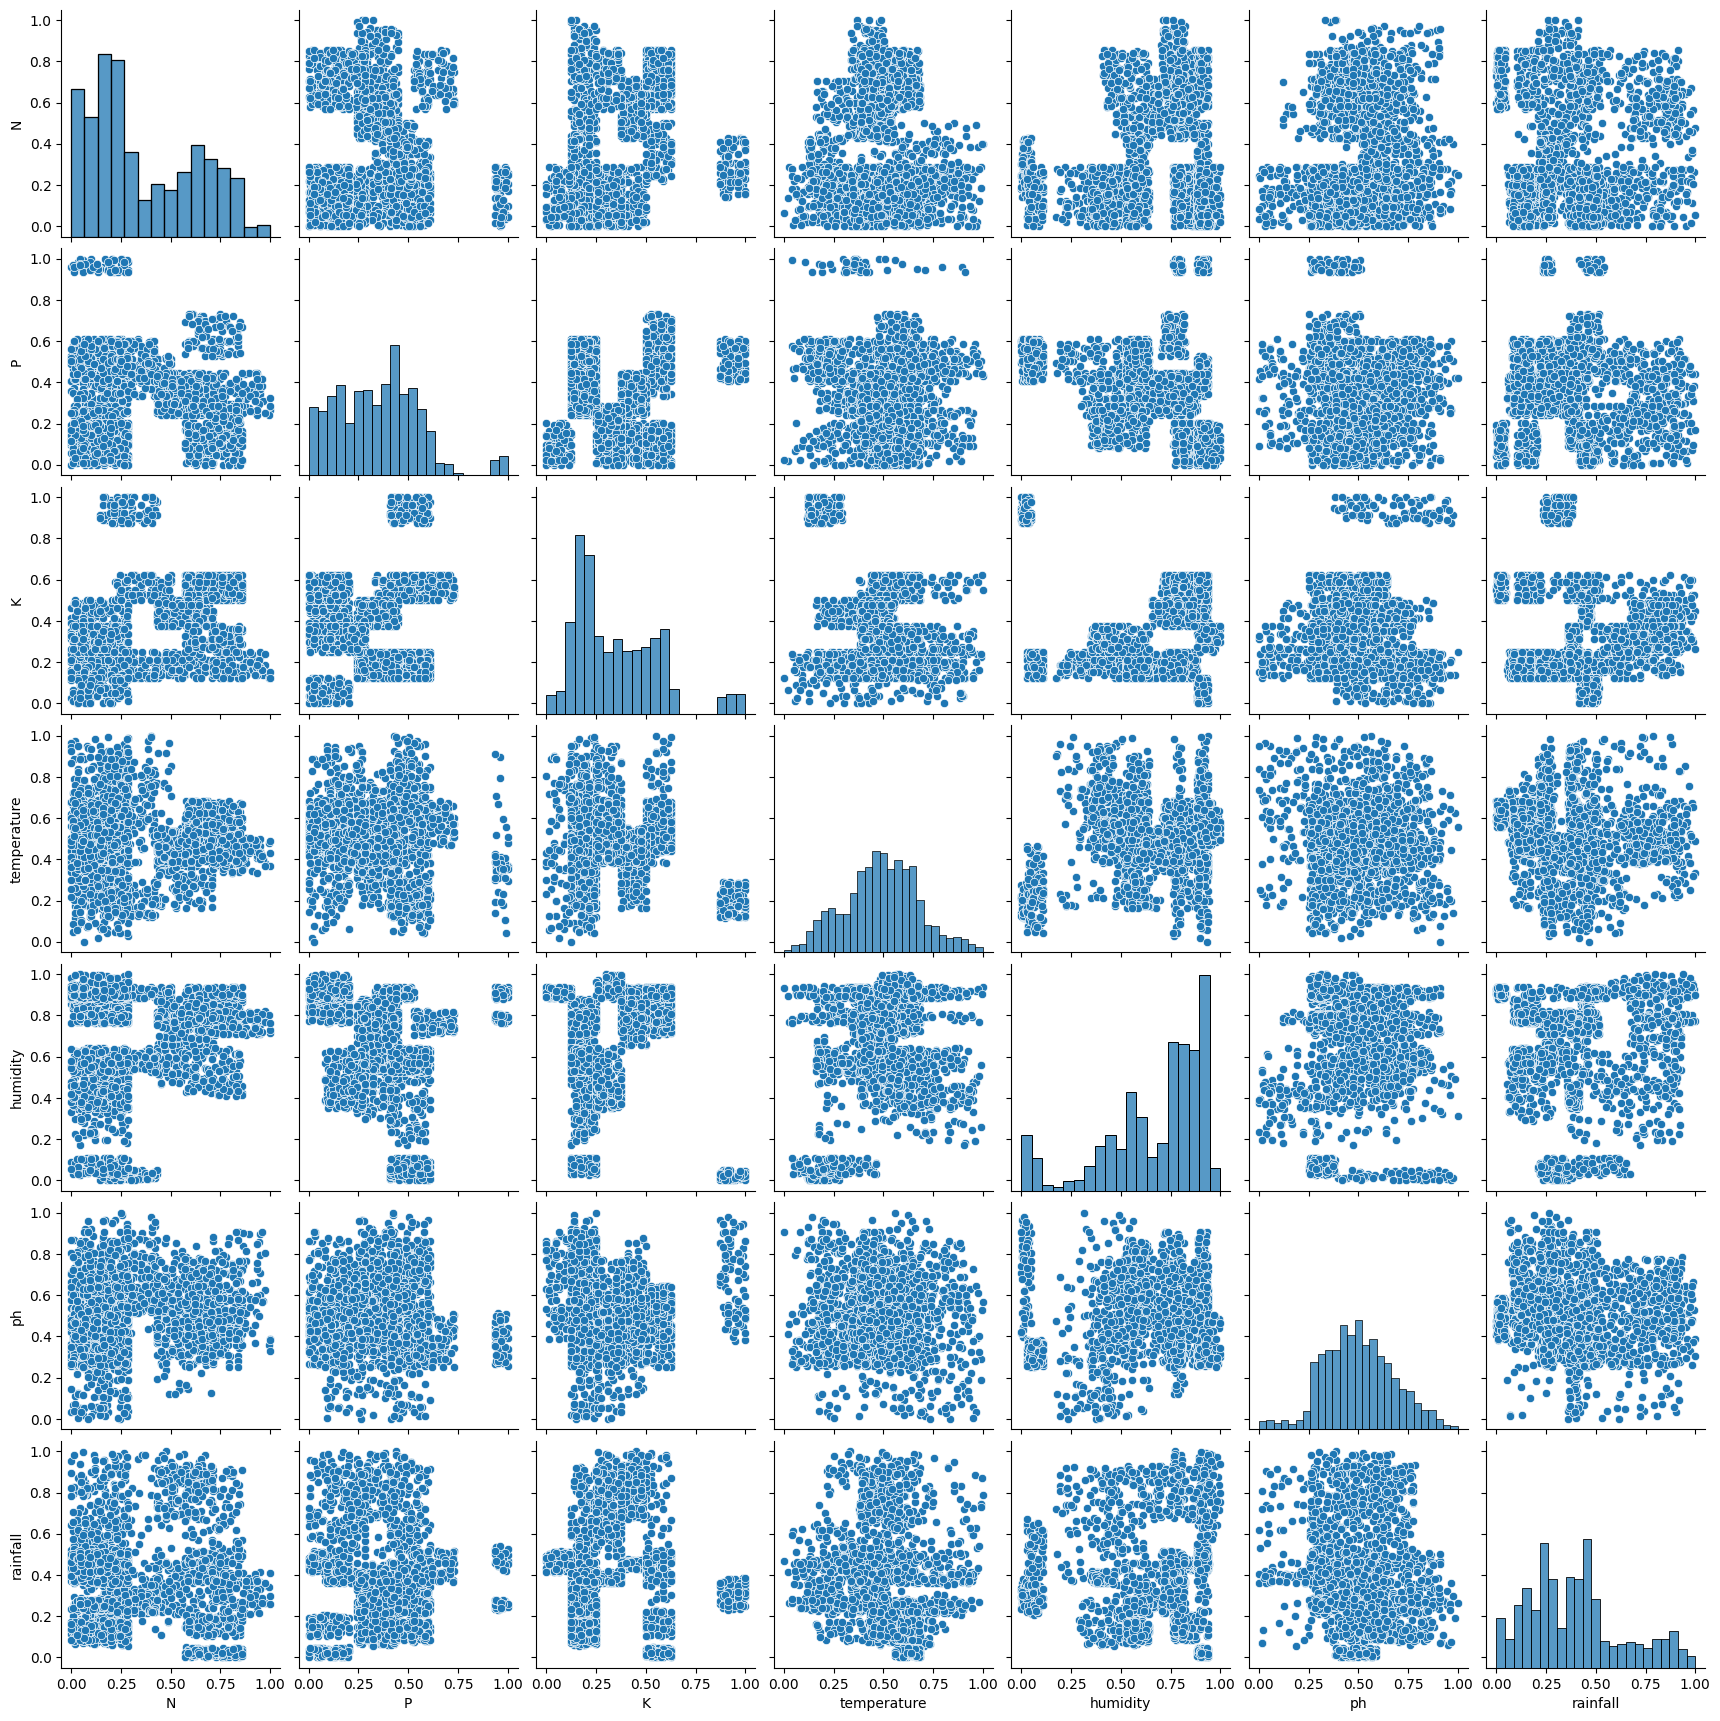

In [21]:
# Assuming X_normalized and y are your features and target variable
sns.pairplot(X_normalized)
plt.show()